# 競馬AI: 学習データ探索ノートブック

このノートブックは、学習データの形式と内容を確認するためのものです。

**データセット:**
- `preprocessed_data_v10_leakfix.parquet`: 前処理済み全データ（2.8M行 × 203列）
- `lgbm_datasets_v10_leakfix.pkl`: LGBM学習用データセット（165特徴量）

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語表示設定（任意）
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
sns.set_style('whitegrid')

# 表示設定
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## 1. Parquetデータの読み込み

In [5]:
# 前処理済みデータの読み込み
df = pd.read_parquet('/workspace/data/processed/preprocessed_data_v10_leakfix.parquet')

print(f"データサイズ: {df.shape}")
print(f"期間: {df['date'].min()} ~ {df['date'].max()}")
print(f"総カラム数: {len(df.columns)}")

データサイズ: (2816319, 203)
期間: 1954-10-23 00:00:00 ~ 2025-12-07 00:00:00
総カラム数: 203


## 2. サンプルデータの確認

In [6]:
# 最新のレース10件を表示
recent_races = df.nlargest(10, 'date')
recent_races[['date', 'venue', 'race_number', 'horse_name', 'jockey_id', 'rank', 'odds']].head(10)

,date,venue,race_number,horse_name,jockey_id,rank,odds
2386304,2025-12-07,09,9,ダディーズトリップ,00660,3,53.200001
2409972,2025-12-07,07,11,ヘリオス,01184,14,331.799988
2489122,2025-12-07,07,11,ハギノアレグリアス,05203,6,114.800003
2522210,2025-12-07,07,11,メイショウハリオ,00666,4,16.200001
2532478,2025-12-07,06,9,ヴィントミューレ,01043,10,251.399994
2536782,2025-12-07,07,11,ウィリアムバローズ,01174,16,143.800003
2540481,2025-12-07,06,10,オレデイイノカ,00422,7,64.800003
2549237,2025-12-07,09,10,マイネルエニグマ,01178,16,15.800000
2560351,2025-12-07,09,12,メイショウカイト,01180,3,12.000000
2560767,2025-12-07,09,10,トーホウディアス,01018,17,187.699997


In [7]:
# 特定のレース（1レース分）を詳細表示
sample_race_id = df['race_id'].iloc[0]
sample_race = df[df['race_id'] == sample_race_id]

print(f"レースID: {sample_race_id}")
print(f"出走頭数: {len(sample_race)}")
sample_race[['horse_number', 'horse_name', 'jockey_id', 'odds', 'rank', 'frame_number']].sort_values('horse_number')

レースID: 1999A4000007
出走頭数: 8


,horse_number,horse_name,jockey_id,odds,rank,frame_number
4,1,STOP TRAFFIC,00000,0.0,1,0
3,2,BELLE'S FLAG,00000,0.0,2,0
5,3,CLOSED ESCROW,00000,0.0,3,0
633844,4,シーキングザパール,00666,0.0,4,0
6,5,TOMORROWS SUNSHINE,00000,0.0,5,0
0,6,ENJOY THE MOMENT,00000,0.0,6,0
1,7,LOVE THAT JAZZ,00000,0.0,7,0
2,8,FUNALLOVER,00000,0.0,8,0


## 3. カラム情報の確認

In [9]:
# 全カラムリスト
print("=== 全カラム ===")
for i, col in enumerate(df.columns):
    dtype = df[col].dtype
    null_count = df[col].isna().sum()
    null_pct = null_count / len(df) * 100
    print(f"{i+1:3}. {col:35} ({str(dtype):15}) - NULL: {null_pct:5.1f}%")

=== 全カラム ===
  1. race_id                             (object         ) - NULL:   0.0%
  2. date                                (datetime64[ns] ) - NULL:   0.0%
  3. venue                               (object         ) - NULL:   0.0%
  4. race_number                         (int64          ) - NULL:   0.0%
  5. distance                            (int64          ) - NULL:   0.0%
  6. surface                             (object         ) - NULL:   0.0%
  7. weather                             (object         ) - NULL:   0.0%
  8. state                               (object         ) - NULL:   0.0%
  9. title                               (object         ) - NULL:   0.0%
 10. horse_id                            (object         ) - NULL:   0.0%
 11. jockey_id                           (object         ) - NULL:   0.0%
 12. trainer_id                          (object         ) - NULL:   0.0%
 13. frame_number                        (int64          ) - NULL:   0.0%
 14. horse_number        

## 4. カテゴリ別カラム分類

In [10]:
# カラムをカテゴリ別に分類
id_cols = [c for c in df.columns if 'id' in c.lower() or c in ['race_id', 'horse_name']]
meta_cols = [c for c in df.columns if c in ['date', 'venue', 'race_number', 'distance', 'surface', 'weather', 'state', 'class_level', 'frame_number', 'horse_number', 'age', 'sex', 'impost']]
target_cols = [c for c in df.columns if c in ['rank', 'target', 'time', 'odds', 'popularity', 'payout']]
lag_cols = [c for c in df.columns if c.startswith('lag')]
stat_cols = [c for c in df.columns if any(x in c for x in ['_win_rate', '_top3_rate', '_avg_', '_count', '_n_races'])]
emb_cols = [c for c in df.columns if '_emb_' in c]

print(f"ID系カラム ({len(id_cols)}): {id_cols[:5]}...")
print(f"メタ情報 ({len(meta_cols)}): {meta_cols}")
print(f"ターゲット情報 ({len(target_cols)}): {target_cols}")
print(f"過去走特徴 ({len(lag_cols)}): {lag_cols[:5]}...")
print(f"統計特徴 ({len(stat_cols)}): {stat_cols[:5]}...")
print(f"埋め込み特徴 ({len(emb_cols)}): {emb_cols[:4]}...")

ID系カラム (56): ['race_id', 'horse_id', 'jockey_id', 'trainer_id', 'horse_name']...
メタ情報 (13): ['date', 'venue', 'race_number', 'distance', 'surface', 'weather', 'state', 'frame_number', 'horse_number', 'age', 'sex', 'impost', 'class_level']
ターゲット情報 (4): ['odds', 'popularity', 'rank', 'time']
過去走特徴 (8): ['lag1_rank', 'lag1_last_3f', 'lag1_odds', 'lag1_popularity', 'lag1_last_3f_rank']...
統計特徴 (59): ['jockey_id_n_races', 'jockey_id_win_rate', 'jockey_id_top3_rate', 'trainer_id_n_races', 'trainer_id_win_rate']...
埋め込み特徴 (32): ['horse_id_emb_0', 'horse_id_emb_1', 'horse_id_emb_2', 'horse_id_emb_3']...


## 5. 基本統計量

In [11]:
# 数値カラムの統計
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].describe()

,race_number,distance,frame_number,horse_number,odds,popularity,weight,age,impost,rank,time,weight_diff,sex_num,weather_num,surface_num,state_num,year,month,day,weekday,class_level,lag1_rank,lag1_odds,lag1_popularity,mean_rank_5,mean_last_3f_5,total_races,mean_rank_all,wins_all,win_rate_all,total_prize,jockey_id_n_races,jockey_id_win_rate,jockey_id_top3_rate,trainer_id_n_races,trainer_id_win_rate,trainer_id_top3_rate,sire_id_n_races,sire_id_win_rate,sire_id_top3_rate,class_level_n_races,class_level_win_rate,class_level_top3_rate,jockey_course_n_races,jockey_course_win_rate,jockey_course_top3_rate,sire_course_n_races,sire_course_win_rate,sire_course_top3_rate,trainer_course_n_races,...,trend_win_mid_rate,trend_win_outer_rate,trend_win_front_rate,trend_win_fav_rate,horse_id_emb_0,horse_id_emb_1,horse_id_emb_2,horse_id_emb_3,horse_id_emb_4,horse_id_emb_5,horse_id_emb_6,horse_id_emb_7,jockey_id_emb_0,jockey_id_emb_1,jockey_id_emb_2,jockey_id_emb_3,jockey_id_emb_4,jockey_id_emb_5,jockey_id_emb_6,jockey_id_emb_7,trainer_id_emb_0,trainer_id_emb_1,trainer_id_emb_2,trainer_id_emb_3,trainer_id_emb_4,trainer_id_emb_5,trainer_id_emb_6,trainer_id_emb_7,sire_id_emb_0,sire_id_emb_1,sire_id_emb_2,sire_id_emb_3,sire_id_emb_4,sire_id_emb_5,sire_id_emb_6,sire_id_emb_7,course_experience,course_best_rank,distance_experience,distance_best_rank,first_distance_cat,first_turf,first_dirt,jockey_change_flag,is_career_high_impost,race_member_strength,relative_strength,lag1_race_member_strength,lag1_performance_value,lag1_n_horses
count,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.574837e+06,2.574837e+06,2.574837e+06,1.814262e+06,1.814262e+06,2.816319e+06,2.574837e+06,2.574837e+06,2.816319e+06,2816319.0,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2816319.000,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,...,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06,2.816319e+06
mean,6.686195e+00,1.568473e+03,4.835478e+00,6.932884e+00,3.736105e+01,6.828339e+00,4.637893e+02,4.052846e+00,5.472018e+01,6.798733e+00,9.813508e+01,8.928143e-01,1.472211e+00,1.543237e+00,1.698993e+00,1.592338e+00,2.007185e+03,6.592798e+00,1.568324e+01,4.419559e+00,4.988817e+00,6.677607e+00,3.668121e+01,6.734033e+00,6.446208e+00,2.359311e+02,1.436052e+01,6.418823e+00,1.523820e+00,9.267813e-02,0.0,1.726156e+05,8.402515e-02,2.605998e-01,1.708563e+05,8.677124e-02,2.680401e-01,3.961377e+04,9.116377e-02,2.738431e-01,1390472.875,8.561599e-02,2.658195e-01,1.277972e+04,8.408272e-02,2.608193e-01,2.893190e+03,9.258642e-02,2.762764e-01,1.245746e+04,...,4.936250e-01,2.869581e-01,5.205781e-02,3.705434e-01,-2.841041e-02,5.244317e-02,-1.467217e-02,-7.389023e-03,-1.472552e-02,2.189705e-02,2.831643e-02,-7.449126e-03,-2.448736e-01,-4.845636e-01,6.508706e-01,-5.540587e-01,-1.437425e-03,-2.654756e-01,3.878003e-01,-3.431427e-01,-4.406970e-01,-1.761451e-01,-3.912819e-01,-2.630017e-02,-1.664203e-01,2.692428e-01,9.921732e-03,-2.143810e-02,1.845946e-02,2.450743e-01,-1.112308e-01,-1.258882e-01,-2.359211e-01,-2.445325e-01,2.972936e-01,-1.195843e-01,3.006245e+00,4.002776e+01,7

## 6. 年次データ量の推移

/tmp/ipykernel_71088/719364213.py:11: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_71088/719364213.py:11: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_71088/719364213.py:11: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_71088/719364213.py:11: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_71088/719364213.py:11: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_71088/719364213.py:11: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24180 (

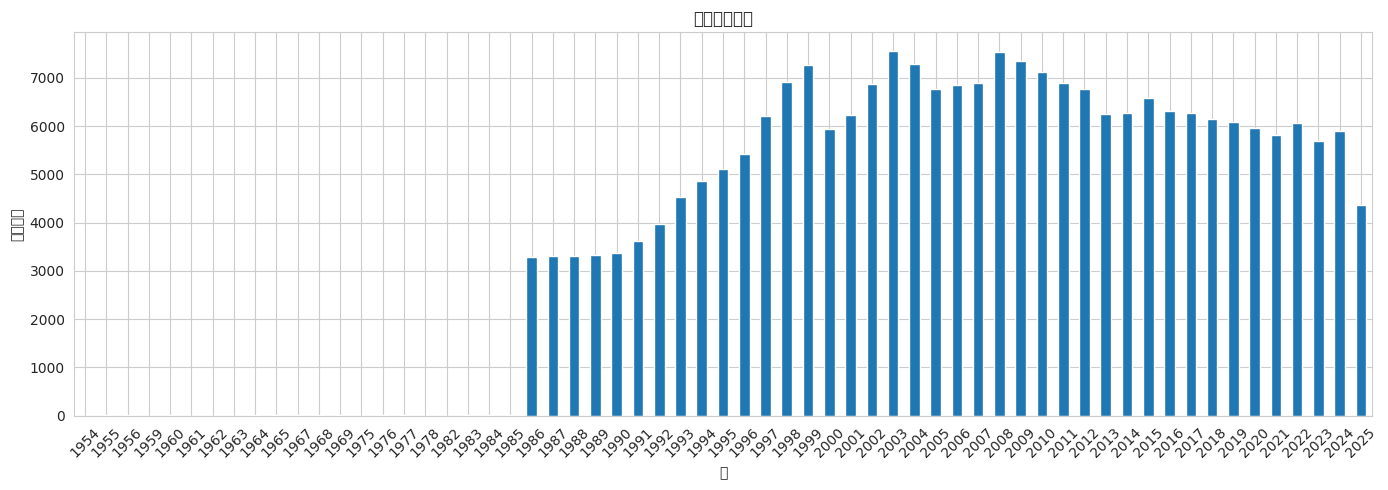

year
2016    6309
2017    6270
2018    6148
2019    6083
2020    5970
2021    5819
2022    6057
2023    5687
2024    5905
2025    4366
Name: race_id, dtype: int64


In [12]:
# 年ごとのレース数
df['year'] = df['date'].dt.year
yearly_counts = df.groupby('year')['race_id'].nunique().sort_index()

plt.figure(figsize=(14, 5))
yearly_counts.plot(kind='bar')
plt.title('年別レース数')
plt.xlabel('年')
plt.ylabel('レース数')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(yearly_counts.tail(10))

## 7. LGBM学習用データセットの確認

In [17]:
# Pickleデータの読み込み
with open('/workspace/data/processed/lgbm_datasets_v10_leakfix.pkl', 'rb') as f:
    datasets = pickle.load(f)

print("=== Train Dataset ===")
print(f"X shape: {datasets['train']['X'].shape}")
print(f"y shape: {datasets['train']['y'].shape}")
print(f"Features: {len(datasets['train']['X'].columns)}")

if 'valid' in datasets:
    print("\n=== Valid Dataset ===")
    print(f"X shape: {datasets['valid']['X'].shape}")
    print(f"y shape: {datasets['valid']['y'].shape}")

if 'test' in datasets:
    print("\n=== Test Dataset ===")
    print(f"X shape: {datasets['test']['X'].shape}")
    print(f"y shape: {datasets['test']['y'].shape}")

=== Train Dataset ===
X shape: (2759644, 165)
y shape: (2759644,)
Features: 165

=== Valid Dataset ===
X shape: (56675, 165)
y shape: (56675,)

=== Test Dataset ===
X shape: (0, 0)
y shape: (0,)


In [18]:
# 特徴量リスト（全165個）
print("=== 全特徴量リスト ===")
for i, col in enumerate(datasets['train']['X'].columns):
    print(f"{i+1:3}. {col}")

=== 全特徴量リスト ===
  1. race_number
  2. distance
  3. frame_number
  4. horse_number
  5. age
  6. impost
  7. weight_diff
  8. sex_num
  9. weather_num
 10. surface_num
 11. state_num
 12. year
 13. month
 14. day
 15. weekday
 16. class_level
 17. lag1_rank
 18. mean_rank_5
 19. mean_last_3f_5
 20. total_races
 21. mean_rank_all
 22. wins_all
 23. win_rate_all
 24. total_prize
 25. jockey_id_n_races
 26. jockey_id_win_rate
 27. jockey_id_top3_rate
 28. trainer_id_n_races
 29. trainer_id_win_rate
 30. trainer_id_top3_rate
 31. sire_id_n_races
 32. sire_id_win_rate
 33. sire_id_top3_rate
 34. class_level_n_races
 35. class_level_win_rate
 36. class_level_top3_rate
 37. jockey_course_n_races
 38. jockey_course_win_rate
 39. jockey_course_top3_rate
 40. sire_course_n_races
 41. sire_course_win_rate
 42. sire_course_top3_rate
 43. trainer_course_n_races
 44. trainer_course_win_rate
 45. trainer_course_top3_rate
 46. sire_dist_n_races
 47. sire_dist_win_rate
 48. sire_dist_top3_rate
 49. sir

In [19]:
# サンプルデータの確認（Train）
X_train = datasets['train']['X']
y_train = datasets['train']['y']

print("=== Train Sample (最初の5行) ===")
X_train.head()

=== Train Sample (最初の5行) ===


,race_number,distance,frame_number,horse_number,age,impost,weight_diff,sex_num,weather_num,surface_num,state_num,year,month,day,weekday,class_level,lag1_rank,mean_rank_5,mean_last_3f_5,total_races,mean_rank_all,wins_all,win_rate_all,total_prize,jockey_id_n_races,jockey_id_win_rate,jockey_id_top3_rate,trainer_id_n_races,trainer_id_win_rate,trainer_id_top3_rate,sire_id_n_races,sire_id_win_rate,sire_id_top3_rate,class_level_n_races,class_level_win_rate,class_level_top3_rate,jockey_course_n_races,jockey_course_win_rate,jockey_course_top3_rate,sire_course_n_races,sire_course_win_rate,sire_course_top3_rate,trainer_course_n_races,trainer_course_win_rate,trainer_course_top3_rate,sire_dist_n_races,sire_dist_win_rate,sire_dist_top3_rate,sire_track_n_races,sire_track_win_rate,...,trend_win_mid_rate,trend_win_outer_rate,trend_win_front_rate,trend_win_fav_rate,horse_id_emb_0,horse_id_emb_1,horse_id_emb_2,horse_id_emb_3,horse_id_emb_4,horse_id_emb_5,horse_id_emb_6,horse_id_emb_7,jockey_id_emb_0,jockey_id_emb_1,jockey_id_emb_2,jockey_id_emb_3,jockey_id_emb_4,jockey_id_emb_5,jockey_id_emb_6,jockey_id_emb_7,trainer_id_emb_0,trainer_id_emb_1,trainer_id_emb_2,trainer_id_emb_3,trainer_id_emb_4,trainer_id_emb_5,trainer_id_emb_6,trainer_id_emb_7,sire_id_emb_0,sire_id_emb_1,sire_id_emb_2,sire_id_emb_3,sire_id_emb_4,sire_id_emb_5,sire_id_emb_6,sire_id_emb_7,course_experience,course_best_rank,distance_experience,distance_best_rank,first_distance_cat,first_turf,first_dirt,jockey_change_flag,is_career_high_impost,race_member_strength,relative_strength,lag1_race_member_strength,lag1_performance_value,lag1_n_horses
0,5,1000,4,4,3,51.5,0,1,2,1,1,1954,10,23,5,5,NaN,NaN,NaN,0,NaN,NaN,0.0,0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.5,0.25,0.2,0.33,0.320888,-0.001521,-2.454275,-0.054011,2.865779,-1.245717,-3.833265,1.183293,-0.54022,-0.95127,1.743883,-1.460387,0.034557,-0.483654,0.878537,-1.017633,-1.087516,-0.727589,0.925392,2.44961,-0.536069,0.094574,0.46847,0.980466,-0.809351,0.913717,-0.686031,-0.33393,-1.480536,1.265933,-0.234386,-2.438757,0,99.0,0,99.0,1,1,0,0,0,8.0,0.0,8.0,0.00,14
1,8,1100,6,6,3,51.0,0,1,1,1,1,1954,11,7,6,5,1.0,NaN,NaN,1,1.0,1.0,1.0,0,1.0,0.999990,0.999990,1.0,0.999990,0.999990,1.0,0.999990,0.999990,1.0,0.999990,0.999990,1.0,0.999990,0.999990,1.0,0.999990,0.999990,1.0,0.999990,0.999990,1.0,0.999990,0.999990,1.0,0.999990,...,0.5,0.25,0.2,0.33,0.320888,-0.001521,-2.454275,-0.054011,2.865779,-1.245717,-3.833265,1.183293,-0.54022,-0.95127,1.743883,-1.460387,0.034557,-0.483654,0.878537,-1.017633,-1.087516,-0.727589,0.925392,2.44961,-0.536069,0.094574,0.46847,0.980466,-0.809351,0.913717,-0.686031,-0.33393,-1.480536,1.265933,-0.234386,-2.438757,1,1.0,1,1.0,0,0,0,0,0,1.0,0.0,8.0,0.18,1
2,2,1100,6,15,3,53.0,0,1,1,1,2,1954,12,4,5,5,1.0,NaN,NaN,2,1.0,2.0,1.0,0,2.0,0.999995,0.999995,2.0,0.999995,0.999995,2.0,0.999995,0.999995,2.0,0.999995,0.999995,2.0,0.999995,0.999995,2.0,0.999995,0.999995,2.0,0.999995,0.999995,2.0,0.999995,0.999995,2.0,0.999995,...,0.5,0.25,0.2,0.33,0.320888,-0.001521,-2.454275,-0.054011,2.865779,-1.245717,-3.833265,1.183293,-0.54022,-0.95127,1.743883,-1.460387,0.034557,-0.483654,0.878537,-1.017633,-1.087516,-0.727589,0.925392,2.44961,-0.536069,0.094574,0.46847,0.980466,-0.809351,0.913717,-0.686031,-0.33393,-1.480536,1.265933,-0.234386,-2.438757,2,1.0,2,1.0,0,0,0,0,1,1.0,0.0,1.0,0.81,1
3,10,1100,4,10,3,52.0,0,1,1,1,2,1954,12,12,6,5,1.0,NaN,NaN,3,1.0,3.0,1.0,0,3.0,0.999997,0.999997,3.0,0.999997,0.999997,3.0,0.999997,0.999997,3.0,0.999997,0.999997,3.0,0.999997,0.999997,3.0,0.999997,0.999997,3.0,0.999997,0.999997,3.0,0.999997,0.999997,3.0,0.999997,...,0.5,0.25,0.2,0.33,0.320888,-0.001521,-2.454275,-0.054011,2.865779,-1.245717,-3.833265,1.183293,-0.54022,-0.95127,1.743883,-1.460387,0.034557,-0.483654,0.878537,-1.017633,-1.087516,-0.727589,0.925392,2.44961,-0.536069,0.094574,0.46847,0

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38918 (\N{CJK UNIFIED IDEOGRAPH-9806}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_f

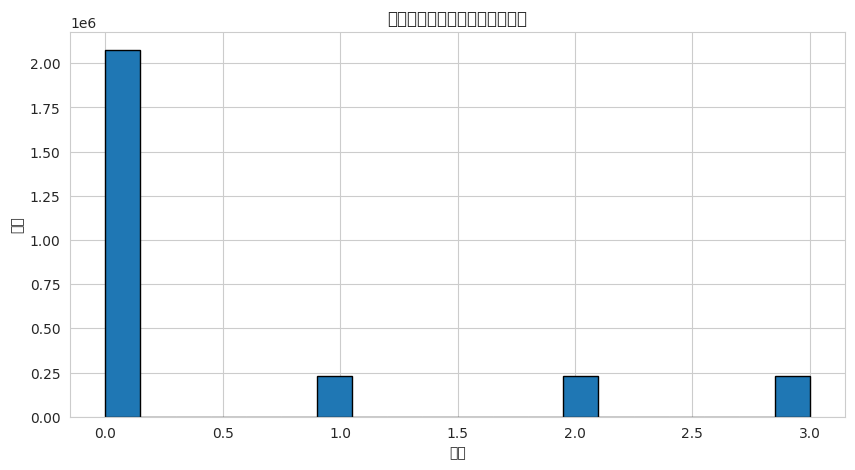

平均順位: 0.50
中央値順位: 0.00


In [20]:
# ターゲット変数（順位）の分布
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=20, edgecolor='black')
plt.title('ターゲット変数（順位）の分布')
plt.xlabel('順位')
plt.ylabel('頻度')
plt.show()

print(f"平均順位: {y_train.mean():.2f}")
print(f"中央値順位: {np.median(y_train):.2f}")

## 8. 主要特徴量の分布

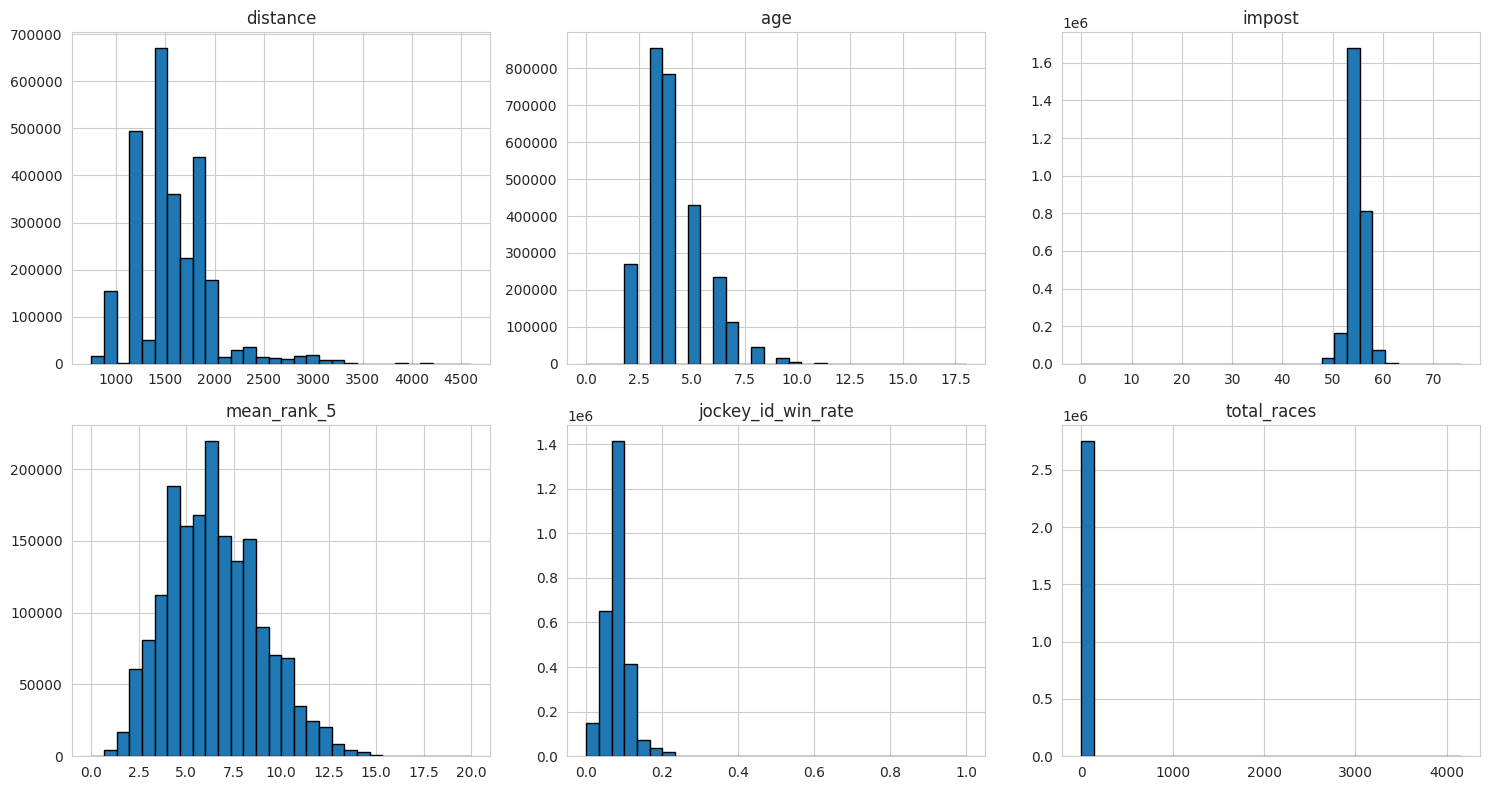

In [21]:
# 主要特徴量の分布をプロット
key_features = ['distance', 'age', 'impost', 'mean_rank_5', 'jockey_id_win_rate', 'total_races']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feat in enumerate(key_features):
    if feat in X_train.columns:
        X_train[feat].hist(bins=30, ax=axes[i], edgecolor='black')
        axes[i].set_title(feat)
        axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

## 9. 相関分析（主要特徴量）

/tmp/ipykernel_71088/4000390788.py:11: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_71088/4000390788.py:11: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_71088/4000390788.py:11: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_71088/4000390788.py:11: UserWarning: Glyph 24500 (\N{CJK UNIFIED IDEOGRAPH-5FB4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_71088/4000390788.py:11: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_71088/4000390788.py:11: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_71088/4000390788.py:11: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8})

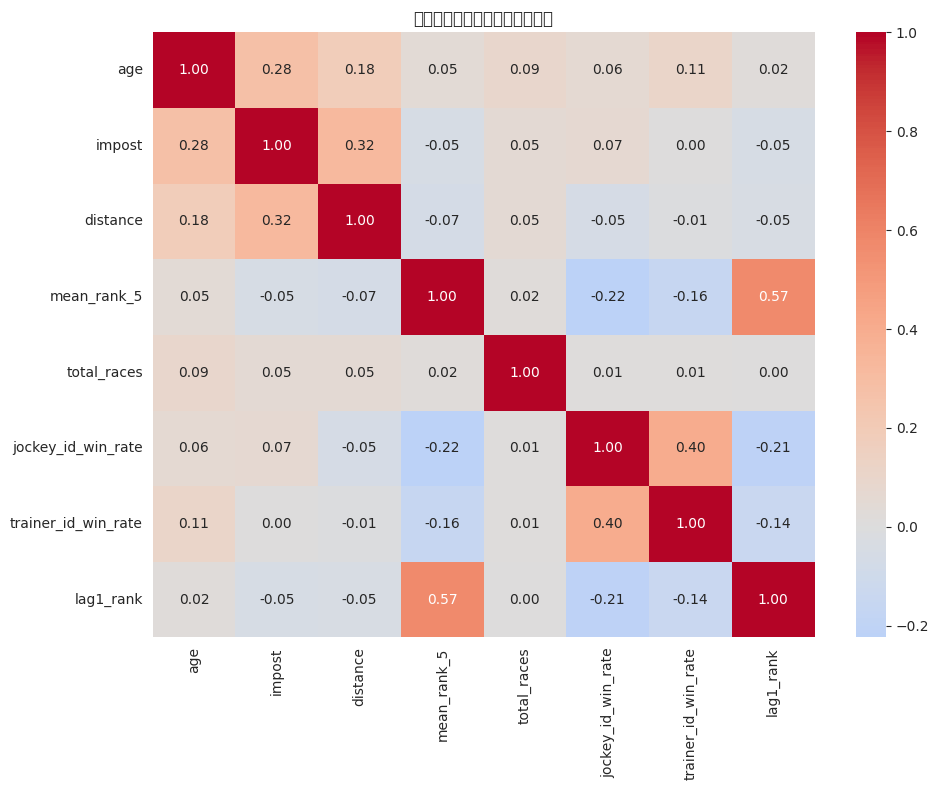

In [22]:
# 主要特徴量の相関マトリックス
analysis_features = ['age', 'impost', 'distance', 'mean_rank_5', 'total_races', 
                     'jockey_id_win_rate', 'trainer_id_win_rate', 'lag1_rank']
analysis_features = [f for f in analysis_features if f in X_train.columns]

corr_matrix = X_train[analysis_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('主要特徴量の相関マトリックス')
plt.tight_layout()
plt.show()

## 10. 2025年データの確認（最新）

In [23]:
# 2025年のデータ
df_2025 = df[df['date'].dt.year == 2025]

print(f"2025年データ: {len(df_2025)}行")
print(f"レース数: {df_2025['race_id'].nunique()}")
print(f"期間: {df_2025['date'].min()} ~ {df_2025['date'].max()}")

# 月別データ量
monthly_2025 = df_2025.groupby(df_2025['date'].dt.month)['race_id'].nunique()
print("\n2025年 月別レース数:")
print(monthly_2025)

2025年データ: 56675行
レース数: 4366
期間: 2025-01-01 00:00:00 ~ 2025-12-07 00:00:00

2025年 月別レース数:
date
1     380
2     423
3     481
4     413
5     439
6     388
7     389
8     425
9     311
10    307
11    338
12     72
Name: race_id, dtype: int64


In [24]:
# 2025年の最新レース5件を詳細表示
latest_2025 = df_2025.nlargest(5, 'date')
latest_2025[['date', 'venue', 'race_number', 'horse_name', 'rank', 'odds', 'popularity']]

,date,venue,race_number,horse_name,rank,odds,popularity
2386304,2025-12-07,09,9,ダディーズトリップ,3,53.200001,11
2409972,2025-12-07,07,11,ヘリオス,14,331.799988,16
2489122,2025-12-07,07,11,ハギノアレグリアス,6,114.800003,11
2522210,2025-12-07,07,11,メイショウハリオ,4,16.200001,8
2532478,2025-12-07,06,9,ヴィントミューレ,10,251.399994,12


## 11. メモ・次のステップ

このノートブックで確認できたこと:
- データは1954年～2025年12月までの約71年分
- 学習用データセットは165特徴量で構成
- ID系カラムは学習データから除外済み
- リーク特徴（odds, rank等）も除外済み

**次のアクション候補:**
1. 特定の特徴量の詳細分析
2. 2024年と2025年のデータ分布比較（環境変化の確認）
3. 外れ値・異常値の検出
4. 特徴量重要度の可視化